In [32]:
import numpy as np
import torch
import pandas as pd
from itertools import product
from torch_geometric.data import Data

evt = "/mnt/data0/Trackml_dataset_100_events/Example_3/trackml_100_events/event000021000-"

def semi_fully_connected_graph(event_path):
    hits = pd.read_csv(event_path + 'hits.csv')
    hits = hits[hits['volume_id'].isin([8,13,17])] #only consider barrel detector
    hits = hits[hits['y'] > 0] #only consider top half of detector
    hits = hits[hits['z'] > 0] #only consider front half of detector
    hits = hits[hits['x'] > 0] #only consider right half of detector

    hits['layer_id'] = hits['volume_id']*10 + hits['layer_id']
    hits = hits.sort_values(by='layer_id')

    #Create graph object with node feature matrix
    graph = Data()
    
    graph.x = torch.tensor(np.arange(0,hits['hit_id'].to_numpy().shape[0],1))
    graph.hit_id = torch.tensor(hits['hit_id'].to_numpy())

    graph.pos = torch.empty(hits['x'].to_numpy().shape[0],3)
    graph.pos[:,0] = torch.tensor(hits['x'].to_numpy())
    graph.pos[:,1] = torch.tensor(hits['y'].to_numpy())
    graph.pos[:,2] = torch.tensor(hits['z'].to_numpy())
    
    edge_index = np.empty((2,1))

    all_layers = hits['layer_id'].unique()

    for i,layer in enumerate(all_layers):
        #Mask hits df to only include hits from current layer and next layer
        current_layer_hits = hits[hits['layer_id'] == layer].to_numpy()
        next_layer_hits = hits[hits['layer_id'] == all_layers[i+1]].to_numpy()
        
        #Get indices of hits in current and next layer
        current_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),current_layer_hits[:,0]))[0]
        next_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),next_layer_hits[:,0]))[0]

        #Create edges between hits in current and next layer
        edge_index = np.concatenate((edge_index,np.array(list(product(current_layer_indices,next_layer_indices))).T), axis=1)
    
        #Break if no next next layer exists
        if all_layers[i] == all_layers[-2]:
            break
        """
        #Mask for next next layer, get indices and create edges between current and next next layer
        next_next_layer_hits = hits[hits['layer_id'] == all_layers[i+2]]
        next_next_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),next_next_layer_hits))[0]
        edge_index = torch.cat((edge_index,torch.tensor(list(product(next_layer_indices,next_next_layer_indices))).T),1).to(torch.int64)
    	"""

    graph.edge_index = torch.tensor(edge_index).to(torch.int64)
    print("Num nodes:",graph.x.shape)
    print("Num edges:",graph.edge_index.shape)
    print("Total number of layers:",hits['layer_id'].unique().shape[0])

    return graph

graph = semi_fully_connected_graph(evt)
torch.save(graph,'hit_graph_tiny_event000021000.pyg')

Num nodes: torch.Size([8560])
Num edges: torch.Size([2, 6582426])
Total number of layers: 10


In [41]:
import random
graph = torch.load('hit_graph_tiny_event000021000.pyg')

#Random filter to remove edges and unconnected nodes
def random_filter(graph, p=0.2):
    n_edges = graph.edge_index.shape[1]
    print('Number of edges before filter:',n_edges)
    assert p >= 0 and p <= 1, 'p must be between 0 and 1'
    if p > 0.5:
        keep_edges = random.sample(range(0,graph.edge_index.shape[1]),int(graph.edge_index.shape[1]*(1-p)))
        graph.edge_index = torch.from_numpy(np.take(graph.edge_index.numpy(),keep_edges,axis=1))
        n_filtered = n_edges - int(n_edges*(1-p))
    else:
        remove_edges = random.sample(range(0,graph.edge_index.shape[1]),int(graph.edge_index.shape[1]*p))
        graph.edge_index = torch.from_numpy(np.delete(graph.edge_index.numpy(),remove_edges,axis=1))
        n_filtered = int(n_edges*p)

    print('Number of edges after filter:',graph.edge_index.shape[1])
    print('Delta:',n_filtered)
    graph = delete_unconnected_nodes(graph)
    return graph

def delete_unconnected_nodes(graph):
    print('Total number of nodes:',graph.num_nodes)
    print('Number of connected nodes:',np.unique(graph.edge_index.numpy()).shape[0])
    graph.x = torch.tensor(np.unique(graph.edge_index.numpy()))
    return graph

graph = random_filter(graph)
torch.save(graph,'hit_graph_tiny_event000021000_filtered.pyg')

print(graph)

Number of edges before filter: 6582426
Number of edges after filter: 5265941
Delta: 1316485
Total number of nodes: 8560
Number of connected nodes: 8560
Data(x=[8560], hit_id=[8560], pos=[8560, 3], edge_index=[2, 5265941])


In [43]:
import torch
import torch_geometric.transforms as T

graph = torch.load('hit_graph_tiny_event000021000.pyg')
print(graph)

linegraph_trafo = T.LineGraph()
print(linegraph_trafo(graph))

Data(x=[8560], hit_id=[8560], pos=[8560, 3], edge_index=[2, 6582426])
Data(hit_id=[8560], pos=[8560, 3], edge_index=[2, 4964001586], num_nodes=6582426)


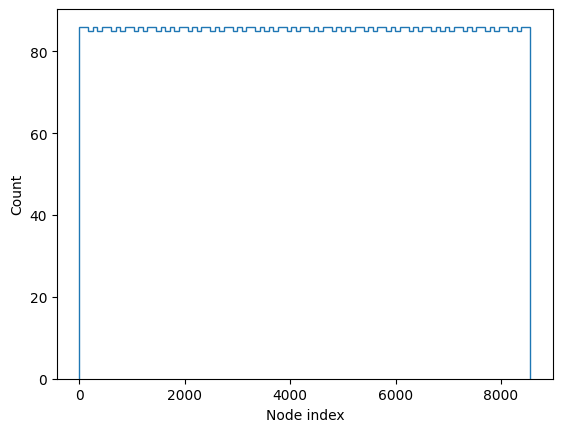

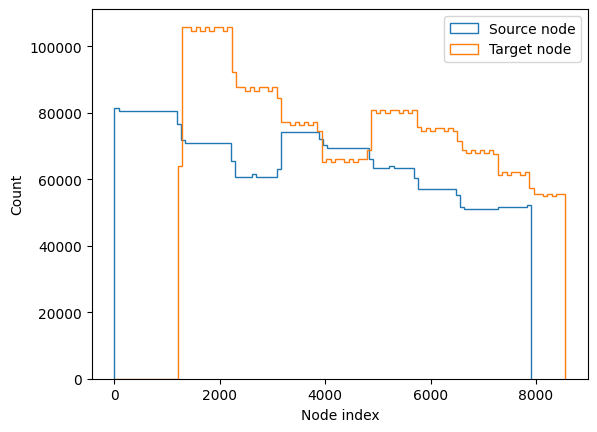

In [53]:
import matplotlib.pyplot as plt

plt.hist(graph.x.numpy(),bins=100, histtype='step')
plt.ylabel('Count')
plt.xlabel('Node index')
plt.show()

plt.hist(graph.edge_index.numpy()[0,:],bins=100, label='Source node', histtype='step')
plt.hist(graph.edge_index.numpy()[1,:],bins=100 ,label='Target node', histtype='step')
plt.ylabel('Count')
plt.xlabel('Node index')
plt.legend()
plt.show()

In [56]:
from itertools import combinations
import torch
import torch_geometric.transforms as T

linegraph_trafo = T.LineGraph()

def build_fc_graph(n_nodes):
    '''
    Builds a fully connected graph with n_nodes, no self-loops and only edges in one direction
    '''
    graph = Data()
    graph.x = torch.tensor(range(n_nodes))
    graph.num_nodes = n_nodes
    edge_index_list = combinations(range(n_nodes),r=2)
    graph.edge_index = torch.tensor(list(edge_index_list)).T
    return graph

def iterate_linegraph(graph, n, filter=False):
    print("Original graph:",graph)
    for i in range(n):
        graph = linegraph_trafo(graph)
        print(graph)
        if graph.edge_index != None: 
            if filter:
                graph = random_filter(graph, p=0.01)
            print("Linegraph iteration",i,":",graph)
            print()
            continue
        
iterate_linegraph(build_fc_graph(10),3,filter=False)

Original graph: Data(x=[10], num_nodes=10, edge_index=[2, 45])
Data(num_nodes=45, edge_index=[2, 120])
Linegraph iteration 0 : Data(num_nodes=45, edge_index=[2, 120])

Data(num_nodes=120, edge_index=[2, 210])
Linegraph iteration 1 : Data(num_nodes=120, edge_index=[2, 210])

Data(num_nodes=210, edge_index=[2, 252])
Linegraph iteration 2 : Data(num_nodes=210, edge_index=[2, 252])

